# Soccer Analytics Part 2: Causal Inference

## Causal Analysis of factors influencing market value of soccer players

## 1. Introduction

In the part 1 of this project, I had created a regression model to predict the market value of soccer players, using a dataset that included various attributes of players. This model provided an initial understanding of the different factors affecting a player's value in the soccer transfer market.

Building upon the insights gained from this initial analysis, in Assignment 2, I am focusing on a specific aspect of player valuation: their contract expiry. The expiration of a player's contract is a crucial point in the transfer market, potentially altering their market value significantly. This stage is critical for strategic negotiations and decisions, as players may seek new opportunities, contract extensions, or even experience a shift in their market appeal.

So, the underlying dynamics at play during this stage offers a strong reasoning to perform causal inference analysis, enabling us to isolate and understand the causal effect of being in the final year of a contract on a player's market value.

## 2. Hypothesis

The core hypothesis driving this causal inference analysis is that "The market value of soccer players is negatively influenced as they enter the final year of their contract". This hypothesis is based on the premise that when a player is in their final year of contract, it would be a more strategic decision for a club to defer offering a contract to a player for a short duration until contract expiry to avoid paying the transfer fee. This anticipation not only pressures the selling club into possibly accepting a lower fee but also introduces a strategic dimension into player valuation, underscoring the relationship between contract duration and market dynamics.

The analysis in this notebook aims to test this hypothesis using causalml to quantify the effect and provide empirical backing to understand the causal impact of contract expiry on a player's market valuation.

## 3. Data Acquisition

### 3.1 Import Required Libraries

In [1]:
%%capture
!pip install causalml
!pip install duecredit

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 3.2 Import Dataset

In [1]:
players = pd.read_csv('fifa_players.csv')

## 4. Data Exploration

Let's do some basic data exploration to review the dataset. (Detailed data exploration steps for this dataset has already been covered in the Assignment-1 notebook)

### 4.1 Quick look at the data structure

In [2]:
players_data_explore = players.copy()


players_data_explore.head()

,value_eur_mn,age,height_cm,weight_kg,club_country,club_playing_status,club_contract_valid_until_year,work_rate_attack_defense,body_type,position,overall,pace,shooting,passing,dribbling,defending,physic,skill_moves
0,181.5,24,182,75,France,starting_xi,2024,High/Low,Unique,Forward,91,97,90,80,92,36,78,5.0
1,185.0,22,195,94,England,starting_xi,2027,High/Medium,Unique,Forward,91,89,93,66,80,45,88,3.0
2,103.0,32,181,75,England,substitute,2025,High/Medium,Unique,Midfield,91,72,88,94,87,65,78,4.0
3,41.0,36,169,67,USA,starting_xi,2025,Low/Low,Unique,Forward,90,80,87,90,94,33,64,4.0
4,51.0,35,185,81,Saudi Arabia,starting_xi,2026,Medium/Medium,Normal,Forward,90,79,88,83,87,39,78,4.0


### 4.2 Plot Histogram to view the distribution of all features

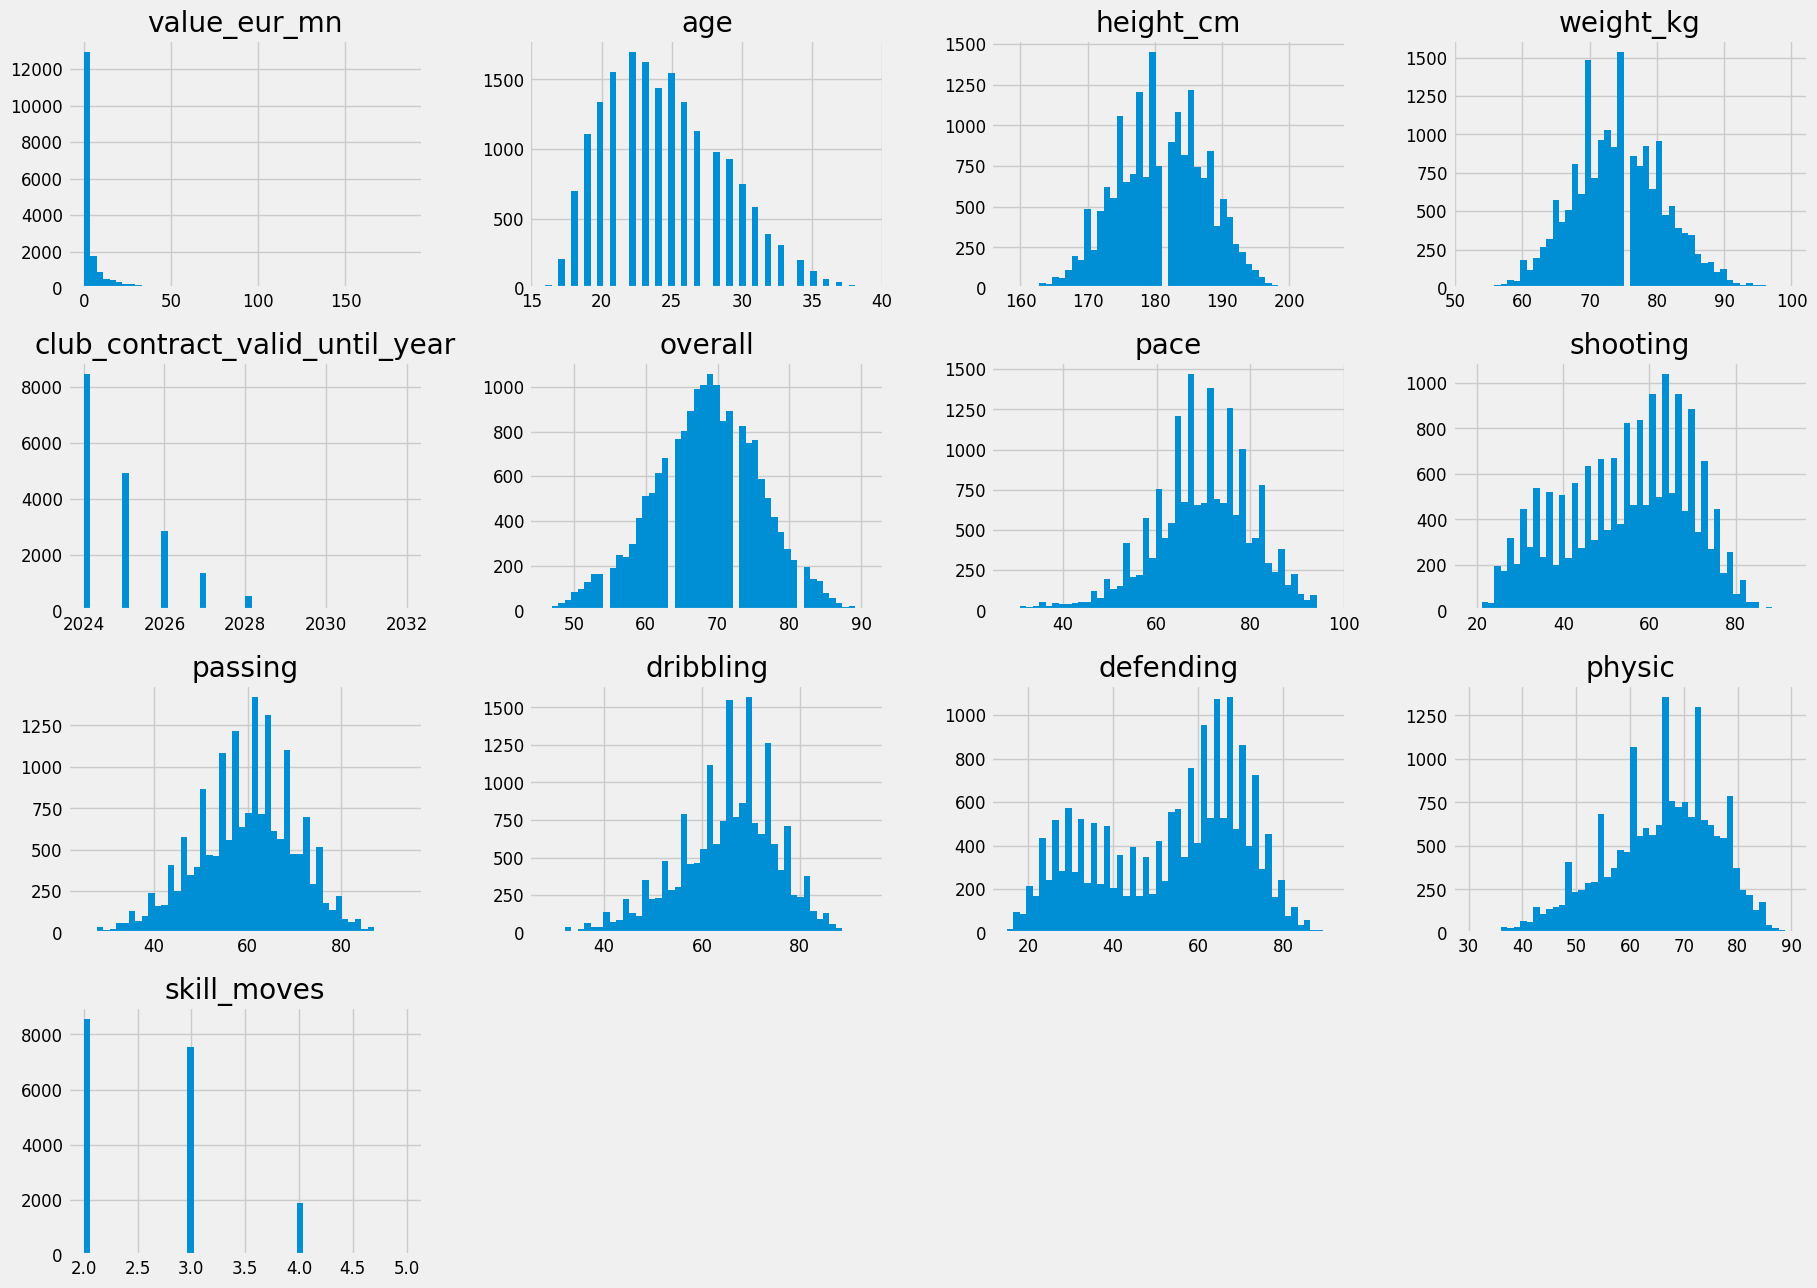

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
players_data_explore.hist(bins=50, figsize=(20,15))
plt.show()

### 4.3 Plot the correlation matrix

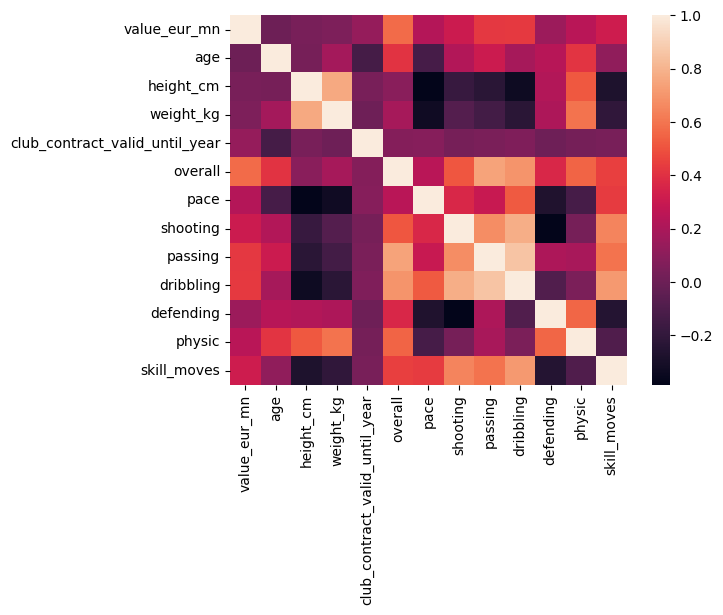

In [6]:
import seaborn as sns
sns.heatmap(players_data_explore.select_dtypes(exclude=['object']).corr());

## 5. Data Preparation for Causal Inference Analysis

### 5.1 Data Preprocessing (using Transformation pipeline created for Assignment 1)

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# 5.1.1 Custom Transformer to add remaining contract years
class AddRemContractYears(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    def fit(self, X, y=None):
        self.club_contract_valid_until_year_ix = X.columns.get_loc(self.column_name)
        return self
    def transform(self, X):
        X = X.values
        rem_contract_yrs = X[:, self.club_contract_valid_until_year_ix] - 2024
        X_transformed = np.c_[X, rem_contract_yrs]

        X_transformed = np.delete(X_transformed, [self.club_contract_valid_until_year_ix], axis=1)

        return X_transformed

# 5.1.2 Custom Transformer to add work rate
class AddWorkRate(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    def fit(self, X, y=None):
        self.work_rate_attack_defense_ix = X.columns.get_loc(self.column_name)
        return self
    def transform(self, X):
        X = X.values
        work_rate_split = np.array([x.split('/') for x in X[:, self.work_rate_attack_defense_ix]])
        work_rate_attack = work_rate_split[:, 0]
        work_rate_defense = work_rate_split[:, 1]

        X_transformed = np.c_[X, work_rate_attack, work_rate_defense]

        X_transformed = np.delete(X_transformed, [self.work_rate_attack_defense_ix], axis=1)

        return X_transformed

# 5.1.3 Pipeline for Numeric Attributes
num_pipeline = Pipeline([
        ('add_rem_contract_yrs', AddRemContractYears(column_name="club_contract_valid_until_year")),
        ('imputer', SimpleImputer(strategy="median")),
    ])


# 5.1.4 Pipeline for Categorical Attributes
cat_pipeline = Pipeline([
    ('add_work_rate', AddWorkRate(column_name="work_rate_attack_defense")),
    ('encoder', OneHotEncoder()),
])


# 5.1.5 Column Transformer to combine preprocessing steps
num_attribs = list(players.select_dtypes(exclude=['object']).columns)
cat_attribs = ["club_country", "club_playing_status", "work_rate_attack_defense", "body_type", "position"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

players_prepared = full_pipeline.fit_transform(players)


# 5.1.6 Convert the preprocessed data back to a dataframe
cat_attribs_final = []
for col in full_pipeline.named_transformers_["cat"].named_steps['encoder'].categories_:
    cat_attribs_final.extend(col)

for i in range(20,23):
    cat_attribs_final[i] = "WorkRateAttack_" + cat_attribs_final[i]
for i in range(23,26):
    cat_attribs_final[i] = "WorkRateDefense_" + cat_attribs_final[i]

num_attribs_final = [attr for attr in num_attribs if attr != 'club_contract_valid_until_year']
attributes = num_attribs_final + ['rem_contract_yrs'] + cat_attribs_final

players_prepared_df = pd.DataFrame(data=players_prepared, columns=attributes)

### 5.2 Choosing the Target, Control Features and Treatment

- **Target Variable**: Current market value of a player

- **Control Features**: All other player attributes except market value (target), and treatment

- **Treatment Group**: Players who are in the last year of their contract i.e. contract expiry year = 2024 (treatment=1)

- **Control Group**: Players who have more than 1 year remaining in their contract i.e contract expiry year >=2025 (treatment=0)

In [5]:
# 5.2.1 Target Variable - Player market value
y = players_prepared_df['value_eur_mn']

# 5.2.2 Control Features - All features except the target and treatment
X = players_prepared_df.drop(['value_eur_mn','rem_contract_yrs'], axis=1)

# 5.2.3 Treatment - Remaining Contract Years (we need to adjust this to set it equal to 1 for players who are in the last year of their contract and 0 for others)
treatment = players_prepared_df['rem_contract_yrs'].apply(lambda x: 1 if x == 0 else 0)

## 6. Calculate Average Treatment Effect (ATE)

### 6.1 S-Learner using LinearRegression

In [ ]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

# After calling estimate_ate, add pretrain=True flag to skip training
# This flag is applicable for other meta learner
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, pretrain=True)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([-0.49283463]), array([-0.76865828]), array([-0.21701097]))
ATE estimate: -0.493
ATE lower bound: -0.769
ATE upper bound: -0.217
(array([-0.49283463]), array([-0.76865828]), array([-0.21701097]))
ATE estimate: -0.493
ATE lower bound: -0.769
ATE upper bound: -0.217


### 6.2 T-Learner using XGBoost

In [ ]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

Using the ready-to-use XGBTRegressor class
(array([-0.38724805]), array([-0.50154133]), array([-0.27295477]))

Using the BaseTRegressor class and using XGB (same result):
(array([-0.38724805]), array([-0.50154133]), array([-0.27295477]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([-0.52889949]), array([-0.79798556]), array([-0.25981342]))


### 6.3 Calculate Propensity Score

Next, we want to analyze the causal effect with propensity score input. The propensity score provides the probability of receiving the treatment given the covariates (in this case, the features of the soccer players).

 It will help in balancing the treated and control groups to reduce selection bias. It matches players who are similar across other observed characteristics but differ in their contract status (final year vs. not), allowing for a more accurate estimation of the causal effect of being in the final year of a contract on a player's market value.

 I am using Logistic Regression to calculate propensity scores, where the target variable is the treatment assignment (the binary variable indicating whether a player is in the final year of their contract or not), and the predictors are the covariates (other attributes of players).

In [ ]:
from sklearn.linear_model import LogisticRegression

# Fit a logistic regression model to predict treatment assignment
logistic_model = LogisticRegression()
logistic_model.fit(X, treatment)

# Calculate propensity scores as the predicted probabilities of treatment
propensity_scores = logistic_model.predict_proba(X)[:, 1]

### 6.4 X-Learner with propensity score input

In [ ]:
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=propensity_scores)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=propensity_scores)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

Using the BaseXRegressor class and using XGB:
(array([-0.34256995]), array([-0.42885663]), array([-0.25628327]))

Using the BaseXRegressor class and using Linear Regression:
(array([-0.52889949]), array([-0.79798556]), array([-0.25981342]))


### 6.5 X-Learner without propensity score input

In [ ]:
# X Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseXRegressor class and using XGB without propensity score input:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseXRegressor class and using Linear Regression without propensity score input:')
print(ate_x)

Using the BaseXRegressor class and using XGB without propensity score input:
(array([-0.35262533]), array([-0.43882921]), array([-0.26642146]))

Using the BaseXRegressor class and using Linear Regression without propensity score input:
(array([-0.52889949]), array([-0.79798556]), array([-0.25981342]))


### 6.6 R-Learner with propensity score input

In [ ]:
# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=propensity_scores)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=propensity_scores)
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r)

Using the BaseRRegressor class and using XGB:
(array([-0.3090939]), array([-0.31061751]), array([-0.30757028]))
Using the BaseRRegressor class and using Linear Regression:
(array([-0.51926273]), array([-0.52127294]), array([-0.51725252]))


### 6.7  R-Learner without propensity score input

In [ ]:
# R Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using XGB without propensity score input:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using Linear Regression without propensity score input:')
print(ate_r)

Using the BaseRRegressor class and using XGB without propensity score input:
(array([-0.28599937]), array([-0.28752356]), array([-0.28447518]))
Using the BaseRRegressor class and using Linear Regression without propensity score input:
(array([-0.76191031]), array([-0.76392544]), array([-0.75989518]))


## 7. Calculate Individual Treatment Effect (ITE/CATE)

In [6]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=propensity_scores)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)

# R Learner with propensity score input
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=propensity_scores)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=treatment, y=y)

In [7]:
# CATE for the first player (K Mbappe) using S Learner
ite_mbappe = cate_s[0]
print(f"The estimated ITE for K Mbappe: {ite_mbappe}")

The estimated ITE for K Mbappe: [-0.49283463]


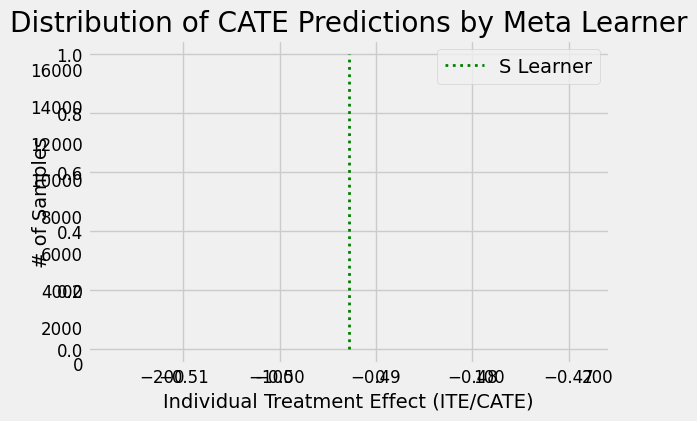

In [ ]:
alpha=0.2
bins=30
plt.figure(figsize=(6,4))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

## 8. Model Interpretation: Feature Importance

In [ ]:
from lightgbm import LGBMRegressor

# specify model for model_tau
model_tau = LGBMRegressor(importance_type='gain',verbose=-1)

base_algo = LGBMRegressor(verbose=-1)

w_multi = np.array(['treatment' if x == 1 else 'control' for x in treatment])
slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

array([-0.28992191])

In [ ]:
%%capture
slearner_tau = slearner.fit_predict(X, w_multi, y)
feature_importance = slearner.get_importance(X=X, tau=slearner_tau, normalize=True, method='auto', features=X.columns)

In [ ]:
feature_importance

{'treatment': overall                   0.695670
 age                       0.093663
 passing                   0.031361
 shooting                  0.020371
 England                   0.020333
 pace                      0.019074
 defending                 0.018560
 weight_kg                 0.016958
 height_cm                 0.016932
 dribbling                 0.013263
 WorkRateAttack_High       0.007616
 WorkRateDefense_High      0.007198
 WorkRateAttack_Medium     0.006211
 Italy                     0.005484
 Portugal                  0.005133
 Lean                      0.004825
 physic                    0.003298
 skill_moves               0.002268
 WorkRateDefense_Medium    0.002123
 Midfield                  0.001723
 Defender                  0.001686
 Unique                    0.001625
 Germany                   0.001015
 Spain                     0.001008
 starting_xi               0.000863
 Forward                   0.000811
 Normal                    0.000669
 substitute    

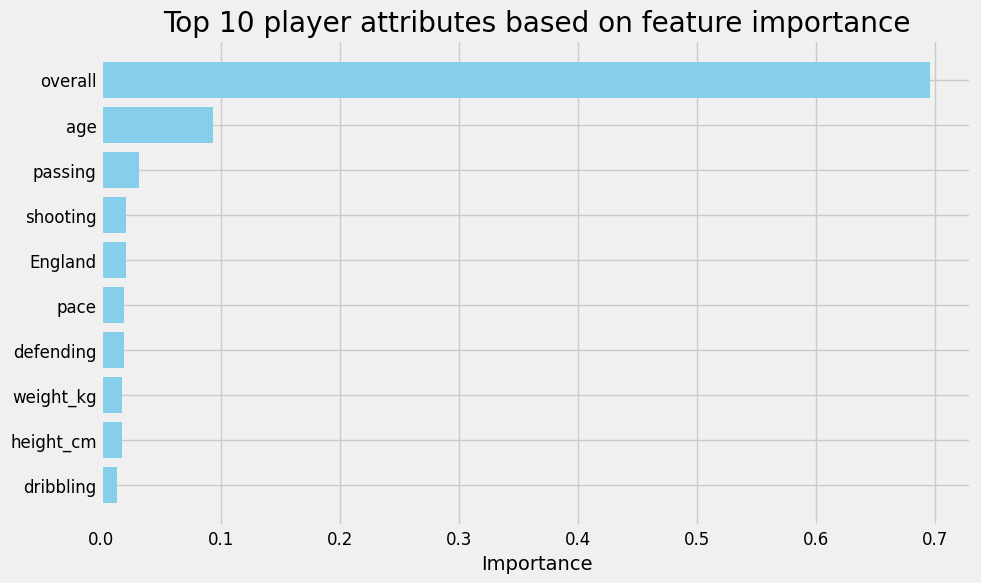

In [ ]:
top_features = dict(sorted(feature_importance['treatment'].items(), key=lambda item: item[1], reverse=True))
top_10_features = dict(list(top_features.items())[:10])

plt.figure(figsize=(10, 6))
plt.barh(list(top_10_features.keys()), list(top_10_features.values()), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 player attributes based on feature importance')
plt.gca().invert_yaxis()
plt.show()

## 9. Model Interpretation: SHAP Values

In [ ]:
%%capture
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)

In [ ]:
np.mean(np.abs(shap_slearner['treatment']),axis=0)

array([2.33349606e-01, 4.45717270e-02, 3.26246576e-02, 6.54668895e-01,
       3.31314743e-02, 3.71064187e-02, 7.08663626e-02, 2.14505854e-02,
       2.40536268e-02, 7.42897969e-03, 6.90347381e-03, 3.66720778e-02,
       0.00000000e+00, 1.07082087e-03, 1.43665567e-02, 0.00000000e+00,
       1.05450341e-02, 0.00000000e+00, 4.93999055e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.31082538e-03, 6.64833100e-04,
       9.32085889e-03, 1.57311918e-03, 0.00000000e+00, 1.55096341e-03,
       5.62652745e-03, 8.20941924e-03, 2.56534999e-03, 2.15437295e-02,
       0.00000000e+00, 1.55157936e-02, 2.07800023e-02, 2.19773648e-04,
       1.18123472e-02])

In [ ]:
%%capture
fig, ax = plt.subplots()
slearner.plot_shap_values(X=X, tau=slearner_tau, features=X.columns)

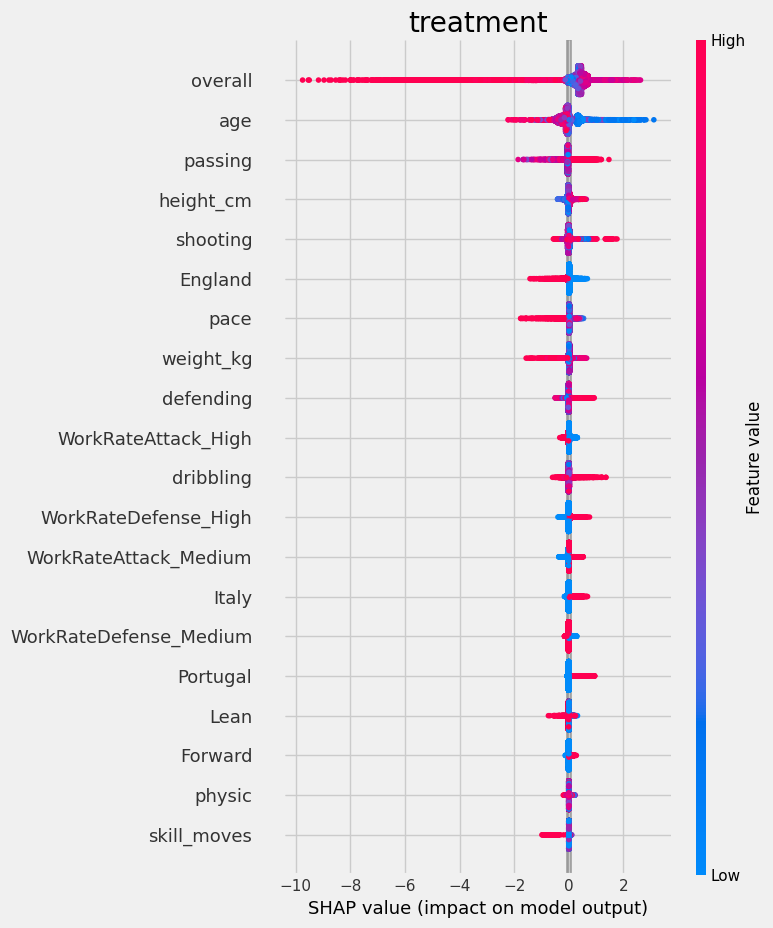

In [ ]:
from IPython.display import display
display(fig)

## 10. Analysis of Results

### 10.1 Average Treatment Effect (ATE) using different learners

| Model | Method | ATE Estimate | Lower Bound | Upper Bound |
|-------|--------|--------------|-------------|-------------|
| S-learner | Linear Regression | -0.493 | -0.769 | -0.217 |
| T-learner | XGBoost | -0.387 | -0.502 | -0.273 |
| T-learner | Linear Regression | -0.529 | -0.798 | -0.260 |
| X-learner | XGB with Propensity Score | -0.343 | -0.429 | -0.256 |
| X-learner | Linear Regression with Propensity Score | -0.529 | -0.798 | -0.260 |
| X-learner | XGB without Propensity Score | -0.353 | -0.439 | -0.266 |
| X-learner | Linear Regression without Propensity Score | -0.529 | -0.798 | -0.260 |
| R-learner | XGB with Propensity Score | -0.309 | -0.311 | -0.308 |
| R-learner | Linear Regression with Propensity Score | -0.519 | -0.521 | -0.517 |
| R-learner | XGB without Propensity Score | -0.286 | -0.288 | -0.284 |
| R-learner | Linear Regression without Propensity Score | -0.762 | -0.764 | -0.760 |


**Interpretation of ATE Estimates from different learners**:

1. **Interpretation of Negative ATE**: Across all models, the negative ATE estimates suggest that being in the final year of a player's contract tends to decrease their market value. This aligns with the initial hypothesis that players nearing the end of their contracts may be perceived as less valuable due to the potential for clubs to acquire them without a transfer fee in the near future.

2. **Consistency in Linear Regression**: Linear Regression consistently shows more negative ATE estimates across different learners (S, T, X, R), suggesting a stronger effect of being in the final year of a contract on reducing a player's market value compared to models using XGBoost.

3. **Confidence Intervals**: The confidence intervals for R-learner models, especially with XGB, are notably narrower (e.g., -0.311 to -0.308) than those for other models. This indicates a higher level of precision in the R-learner's estimates, possibly due to the model's ability to better handle the complexity of the data or the inclusion of propensity scores.

4. **Effect of Propensity Scores**: For X and R learners, incorporating propensity scores does not uniformly improve the confidence intervals across models. However, it seems to slightly increase the ATE estimate's precision in some cases, such as the X-learner with XGB, suggesting that propensity score adjustment can influence the estimated treatment effect's stability.

5. **Variability in Estimates**: The ATE estimates vary across different models, ranging from -0.762 to -0.286. This variation shows the sensitivity of causal inference results to the choice of model and methodology.

### 10.2 Individual Treatment Effect (ITE/CATE)

Looking at the Individual Treatment Effect (ITE) shifts the focus from the average impact of the treatment across all players to the impact of the treatment on individual players. This analysis can provide personalized insights, especially for clubs who are targeting to buy specific players. Also, by examining ITE, clubs can identify specific players who are most likely to experience a significant increase in market value as they enter the final year of their contracts. This information can guide negotiations, whether it involves renewing contracts early to avoid market value spikes or waiting to sell players at their peak value.

For example, in Section 7, I have calculated the ITE for one of the most popular players in the world today, K Mbappe, who is in the final year of his contract. The estimated ITE is -0.4928, which represents the predicted change in his market value due to being in the final year of his contract, compared to if he were not in the final year. The negative sign indicates a decrease in market value attributable to this specific condition. This scenario might impact how clubs, including his current club and potential future clubs, approach contract negotiations. The perceived decrease in market value might lead to more cautious offers from other clubs or even his current club, assuming they might acquire or retain him for a lower fee or wage than expected if he had more time left on his contract.

### 10.3 Feature Importance

Feature importance scores are calculated in Section 8 of this notebook using the S-learner with LightGBMRegressor. Analyzing the feature importance can provide valuable insights into what factors most significantly influence the average treatment effect (ATE) on a player's market value, especially in the context of being in the final year of their contract. By looking at the results, we get the following insights:

1. **Overall Player Rating**: The 'overall' rating has the highest importance score (0.695670), indicating it is the most influential factor in determining a player's market value when approaching the end of their contract.

2. **Impact of Player Age**: Following the overall rating, 'age' has the next highest importance score (0.093663). Younger players in the final year of their contract might have higher market values due to their potential for future development, whereas older players may see a decline in value due to approaching career end.

3. **Importance of certain skills**: Attributes like 'passing' (0.031361), 'shooting' (0.020371), 'pace' (0.019074), and 'defending' (0.018560) also contribute to the model's predictions, indicating their importance in deciding a player's value.

4. **Physical Attributes**: 'Weight_kg' (0.016958) and 'height_cm' (0.016932) have similar importance scores, indicating physical attributes also play a role in determining market value, likely due to their impact on a player's suitability for certain positions or styles of play.

5. **Playing country**: An interesting observation from the model is that players playing for clubs in 'England' (0.020333) appear to have a higher influence, possibly because the English Premier League is the most popular league in the world, offering high visibility and marketing potential to players leading to higher market value.

### 10.4 SHAP Values

From the SHAP plot created in Section 9, we can get the following insights:

1. **Overall Rating**: The 'overall' rating has the most substantial positive impact on the market value of players. Higher overall ratings are associated with an increase in market value, as indicated by the concentration of points on the right-hand side of the plot.

2. **Age**: The 'age' feature has the next most significant impact, though it shows a mix of positive and negative effects on the market value. This could indicate that younger and older players have different influences on their market value, with possibly younger players tending to increase market value.

3. **Playing in England**: Players who are playing in the English Premier League have a positive impact on market value, suggesting that these players are valued higher in the market.

4. **Work Rates**: Different work rates ('WorkRateAttack_High', 'WorkRateDefense_High', etc.) appear towards the bottom of the plot, indicating that the work rate of players is not considered as much in deciding their market value.

5. **Other Countries and Player Type Features**: Features like 'Italy', 'Portugal', 'Lean', and 'Forward' are at the bottom of the plot, suggesting they have the least impact on the model's predictions. The SHAP values for these features are spread around zero, showing they don't consistently increase or decrease market value across the dataset.

### 10.5 Lessons Learned & Next Steps:

Through this analysis, we have confirmed our initial hypothesis that players in the final year of their contract tend to experience a decrease in market value, with the effect size estimated to be in the range of 0.3 to 0.7 across various models. By examining feature importance scores and SHAP values, we have identified specific factors that significantly influence a player's market value when they are in their final year. This model provides an initial framework for clubs, agents, and other stakeholders in making informed decisions regarding player transactions, such as buying, selling, or renewing contracts.

The next steps for this analysis would be to analyze the treatment effect as a continuous variable. In this model, we have restricted our approach to a binary treatment, focusing solely on whether a player is in their final year of contract. However, we can analyze the remaining contract years as a continuous variable using causal inference packages like econml, which could provide insights about how different durations until contract expiry can causally affect a player's market value.